In [13]:
import sys
import os

api_parent_dir = os.path.abspath(
    os.path.join(os.getcwd(), ".."))  # Move up twice
sys.path.append(api_parent_dir)  # Add parent of `api` to sys.path

print("Current sys.path:")
for path in sys.path:
    print(path)

Current sys.path:
/Users/bryantan/.pyenv/versions/3.12.8/lib/python312.zip
/Users/bryantan/.pyenv/versions/3.12.8/lib/python3.12
/Users/bryantan/.pyenv/versions/3.12.8/lib/python3.12/lib-dynload

/Users/bryantan/.pyenv/versions/3.12.8/envs/new_fyp_env/lib/python3.12/site-packages
/Users/bryantan/Documents/HengOngHuat/backend
/Users/bryantan/Documents/HengOngHuat/backend


In [14]:
import json
import yfinance as yf
import pandas as pd
import numpy as np
from api.utils.StockAnalyzer import StockAnalyzer
import seaborn as sns 
import matplotlib.pyplot as plt

In [15]:
MOCK_PORTFOLIOS_FROM_DB = [
    {
        "name": 'Tech Portfolio',
        "stocks": ['AAPL', 'GOOGL', 'MSFT', 'NVDA'],
        "weights": [0.3, 0.4, 0.2, 0.1],
        "start_date": ['2023-01-01', '2023-01-01'],
        "end_date": ['2023-12-31', '2023-12-31']
    },
    {
        "name": 'Swensen',
        "stocks": ['BBRE', 'BIV', 'IEFA', 'IVV', 'SPEM'],
        "weights": [0.2247, 0.225, 0.075, 0.23461, 0.24069],
        "start_date": ['2023-09-01', '2023-09-01'],
        "end_date": ['2024-01-01', '2024-01-01']
    },
    {
        "name": "Swensen1",
        "stocks": [
            "BBRE",
            "BIV",
            "IEFA",
            "IVV",
            "SPEM"
        ],
        "weights": [
            0.2247,
            0.225,
            0.075,
            0.23461,
            0.24069
        ],
        "start_date": [
            "2023-09-01"
        ],
        "end_date": [
            "2024-01-01"
        ]
    }
]

In [16]:
import json
import yfinance as yf
import pandas as pd
import numpy as np
from api.utils.StockAnalyzer import StockAnalyzer
from yahooquery import Ticker


class PortfolioAnalyzer:
    def __init__(self, stocks, weights, start_date, end_date, initial_investment):
        self.stocks = stocks
        self.weights = [float(w) for w in weights]
        self.start_date = start_date
        self.end_date = end_date
        self.initial_investment = float(initial_investment)

    def convert_data(self, data, round_digit=2):
        result = []
        for col in data.columns:
            for index, row in data.iterrows():
                result.append({
                    "index": index,
                    "ticker": col,
                    "value": round(row[col], round_digit)
                })
        return json.dumps(result, indent=4)

    def download_price_data(self, convert_data=True):
        data = yf.download(self.stocks, start=self.start_date,
                           end=self.end_date)['Close']
        data.index = [str(x.date()) for x in data.index]
        return self.convert_data(data) if convert_data else data

    def get_portfolio_timeseries(self):
        price_data = self.download_price_data(convert_data=False)

        if price_data.empty:
            raise ValueError(
                f"yf.download returned empty data for tickers: {self.stocks} "
                f"and date range: {self.start_date} to {self.end_date}"
            )

        daily_returns = price_data.pct_change().dropna()
        cumprod_returns = (daily_returns + 1).cumprod()
        initial_allocations = {ticker: self.initial_investment * weight
                               for ticker, weight in zip(self.stocks, self.weights)}

        init_series = pd.Series(initial_allocations)
        asset_values = cumprod_returns.multiply(init_series, axis=1)
        asset_values['Portfolio Value'] = asset_values.sum(axis=1)
        asset_values.index = pd.to_datetime(asset_values.index)
        return asset_values

    def get_portfolio_metrics(self, benchmark="^GSPC", risk_free_rate=0.04):
        # Use the updated version with debugging prints and error handling.
        ts = self.get_portfolio_timeseries()
        portfolio_values = ts["Portfolio Value"]
        portfolio_values.index = pd.to_datetime(portfolio_values.index)

        # Cumulative Return
        initial_value = portfolio_values.iloc[0]
        final_value = portfolio_values.iloc[-1]
        cumulative_return = final_value / initial_value - 1

        # Annualized Return (CAGR)
        num_years = (
            portfolio_values.index[-1] - portfolio_values.index[0]).days / 365.25
        annualized_return = (final_value / initial_value) ** (1 /
                                                              num_years) - 1 if num_years > 0 else None

        # Maximum Drawdown
        rolling_max = portfolio_values.cummax()
        drawdown_series = (portfolio_values - rolling_max) / rolling_max
        max_drawdown = drawdown_series.min()

        # Daily Returns for portfolio metrics
        port_daily_returns = portfolio_values.pct_change().dropna()
        annualized_volatility = port_daily_returns.std() * np.sqrt(252)

        # Sharpe Ratio
        rf_daily = (1 + risk_free_rate) ** (1/252) - 1
        excess_returns = port_daily_returns - rf_daily
        sharpe_ratio = (excess_returns.mean() / port_daily_returns.std()) * \
            np.sqrt(252) if port_daily_returns.std() != 0 else None

        # Sortino Ratio
        downside_returns = port_daily_returns[port_daily_returns < rf_daily]
        downside_std = downside_returns.std(
        ) * np.sqrt(252) if len(downside_returns) > 0 else None
        sortino_ratio = ((port_daily_returns.mean() * 252) - risk_free_rate) / \
            downside_std if downside_std and downside_std != 0 else None

        try:
            bench_data = yf.download(
                benchmark, start=self.start_date, end=self.end_date)['Close']
        except Exception as e:
            print("Error downloading benchmark data:", e)
            return None
        bench_data.index = pd.to_datetime(bench_data.index)
        bench_daily_returns = bench_data.pct_change().dropna()
        common_dates = port_daily_returns.index.intersection(
            bench_daily_returns.index)
        if len(common_dates) == 0:
            print("Warning: No common dates between portfolio and benchmark.")
            return None

        port_common = port_daily_returns.loc[common_dates]
        bench_common = bench_daily_returns.loc[common_dates]
        if isinstance(bench_common, pd.DataFrame):
            bench_common = bench_common.iloc[:, 0]

        if len(port_common) != len(bench_common):
            print("Warning: Mismatched lengths between portfolio and benchmark returns.")
            return None

        # Beta: covariance divided by variance
        cov = np.cov(port_common, bench_common)[0, 1]
        var = np.var(bench_common)
        beta = cov / var if var != 0 else None

        # Correlation
        correlation = np.corrcoef(port_common, bench_common)[0, 1]

        # Benchmark annualized return (CAGR for benchmark)
        bench_initial = bench_data.loc[common_dates[0]]
        bench_final = bench_data.loc[common_dates[-1]]
        bench_years = (common_dates[-1] - common_dates[0]).days / 365.25
        bench_annualized_return = (
            bench_final / bench_initial) ** (1 / bench_years) - 1 if bench_years > 0 else None

        # Alpha using CAPM
        alpha = (annualized_return - risk_free_rate) - beta * (bench_annualized_return -
                                                               risk_free_rate) if beta is not None and bench_annualized_return is not None else None

        # Treynor Ratio
        treynor_ratio = (annualized_return - risk_free_rate) / \
            beta if beta and beta != 0 else None

        metrics = {
            "Cumulative Return": cumulative_return,
            "Annualized Return": annualized_return,
            "Max Drawdown": max_drawdown,
            "Annualized Volatility": annualized_volatility,
            "Sharpe Ratio": sharpe_ratio,
            "Sortino Ratio": sortino_ratio,
            "Beta": beta.item() if hasattr(beta, 'item') else beta,
            "Correlation to Benchmark": correlation.item() if hasattr(correlation, 'item') else correlation,
            "Alpha": alpha.item() if hasattr(alpha, 'item') else alpha,
            "Treynor Ratio": treynor_ratio.item() if hasattr(treynor_ratio, 'item') else treynor_ratio
        }
        return json.dumps(metrics, indent=4)

    def get_asset_allocation(self, etf_category_mapping=None):
        """
        Computes asset allocation percentages.
          - For ETFs: if the ETF’s category is a bond category, add the allocation directly.
            Otherwise, if underlying holdings are available, compute effective allocation based on holding percentages.
          - For non-ETFs: if the asset is identified as a bond (using its longName), it is grouped under "Bonds".
        """
        allocation = {}
        bond_categories = {"Intermediate Bonds", "Short Term Bonds",
                           "Long Term Bonds", "International Bonds"}
        for i, ticker in enumerate(self.stocks):
            # Convert to percentage
            portfolio_weight_pct = self.weights[i] * 100
            analyzer = StockAnalyzer(ticker)
            if analyzer.etf:
                etf_metrics = analyzer.get_etf_metrics()
                asset_category = etf_metrics.get("Category", "Others")
                if asset_category in bond_categories:
                    # For bond ETFs, add the allocation directly.
                    allocation[asset_category] = allocation.get(
                        asset_category, 0) + portfolio_weight_pct
                else:
                    holdings_df = analyzer.get_etf_holdings()
                    if not holdings_df.empty:
                        for _, row in holdings_df.iterrows():
                            underlying_symbol = row["symbol"]
                            # Already in percent
                            holding_pct = row["holdingPercent"]
                            effective_allocation = portfolio_weight_pct * holding_pct / 100
                            if etf_category_mapping and underlying_symbol in etf_category_mapping:
                                underlying_asset_class = etf_category_mapping[underlying_symbol]
                            else:
                                underlying_asset_class = asset_category
                            allocation[underlying_asset_class] = allocation.get(
                                underlying_asset_class, 0) + effective_allocation
                    else:
                        allocation[asset_category] = allocation.get(
                            asset_category, 0) + portfolio_weight_pct
            else:
                # For non-ETF stocks, check if it appears to be a bond via its longName.
                asset_info = analyzer.asset_info
                if asset_info and "bond" in asset_info.get("longName", "").lower():
                    allocation["Bonds"] = allocation.get(
                        "Bonds", 0) + portfolio_weight_pct
                else:
                    allocation[ticker] = allocation.get(
                        ticker, 0) + portfolio_weight_pct
        return json.dumps(allocation, indent=4)

    def get_holdings(self, etf_category_mapping=None):
        """
        Returns a detailed breakdown of holdings.
          - For bond ETFs and bonds, displays them directly.
          - For other ETFs, drills down into underlying holdings if available.
          - For non-ETF stocks, displays the ticker and weight.
        """
        holdings = []
        bond_categories = {"Intermediate Bonds", "Short Term Bonds",
                           "Long Term Bonds", "International Bonds"}
        for i, ticker in enumerate(self.stocks):
            portfolio_weight_pct = self.weights[i] * 100
            analyzer = StockAnalyzer(ticker)
            if analyzer.etf:
                etf_metrics = analyzer.get_etf_metrics()
                asset_category = etf_metrics.get("Category", "Others")
                if asset_category in bond_categories:
                    holdings.append({
                        "Bond ETF": ticker,
                        "Weight": portfolio_weight_pct,
                        "Category": asset_category
                    })
                else:
                    holdings_df = analyzer.get_etf_holdings()
                    if not holdings_df.empty:
                        for _, row in holdings_df.iterrows():
                            underlying_symbol = row["symbol"]
                            holding_pct = row["holdingPercent"]
                            effective_weight = portfolio_weight_pct * holding_pct / 100
                            underlying_asset_class = (etf_category_mapping.get(underlying_symbol, asset_category)
                                                      if etf_category_mapping else asset_category)
                            holdings.append({
                                "ETF": ticker,
                                "Underlying_Symbol": underlying_symbol,
                                "Underlying_Name": row["holdingName"],
                                "Effective_Weight": effective_weight,
                                "Asset_Class": underlying_asset_class
                            })
                    else:
                        holdings.append({
                            "Asset": ticker,
                            "Weight": portfolio_weight_pct,
                            "Detail": "No ETF holdings data available"
                        })
            else:
                asset_info = analyzer.asset_info
                if asset_info and "bond" in asset_info.get("longName", "").lower():
                    holdings.append({
                        "Bond": ticker,
                        "Weight": portfolio_weight_pct
                    })
                else:
                    holdings.append({
                        "Asset": ticker,
                        "Weight": portfolio_weight_pct
                    })
        return json.dumps(holdings, indent=4)
    
    # def sector_exposure(self):
    #     sector_weights = {}
    #     bond_etfs = [] 
    #     etfs = []
    #     etf_weights = {}
        
    #     for i, ticker in enumerate(self.stocks):
    #         portfolio_weight = self.weights[i]
    #         analyzer = StockAnalyzer(ticker)
            
    #         if analyzer.etf:
    #             asset_info = analyzer.asset_info
    #             is_bond_etf = False
                
    #             if 'category' in asset_info and asset_info['category']:
    #                 bond_terms = ['Intermediate Core Bond',
    #                               'World Bond', 'Short-Term Bond', 'Long-Term Bond']
    #                 is_bond_etf = any(
    #                     bond_term in asset_info['category'] for bond_term in bond_terms)
                    
    #             if is_bond_etf:
    #                 bond_etfs.append(ticker)
    #                 sector_weights['Fixed Income'] = sector_weights.get('Fixed Income', 0) + portfolio_weight
    #             else:
    #                 etfs.append(ticker)
    #                 etf_ticker = Ticker(ticker)
    #                 sector_weightings = etf_ticker.fund_sector_weightings
                    
    #                 if isinstance(sector_weightings, dict) and sector_weightings:
    #                     # Add weighted sector exposures
    #                     for sector, weight in sector_weightings.items():
    #                         # Convert decimals to percentages
    #                         effective_weight = portfolio_weight * weight
    #                         sector_weights[sector] = sector_weights.get(
    #                             sector, 0) + effective_weight
    #                 else:
    #                     # If sector data isn't available, classify as 'Other'
    #                     sector_weights['Other'] = sector_weights.get(
    #                         'Other', 0) + portfolio_weight
                        
    #         else:
    #             # For individual stocks
    #             sector = analyzer.asset_info.get('sector', 'Other')
    #             sector_weights[sector] = sector_weights.get(
    #                 sector, 0) + portfolio_weight
                
    #     sector_weights = {k: v * 100 for k, v in sector_weights.items()}
        
    #     return json.dumps(sector_weights, indent=4)
    
    def sector_exposure(self):
        sector_weights = {}
        bond_etfs = []
        etfs = []
        etf_weights = {}
        
        for i, ticker in enumerate(self.stocks):
            portfolio_weight = self.weights[i]
            analyzer = StockAnalyzer(ticker)
            
            if analyzer.etf:
                asset_info = analyzer.asset_info
                is_bond_etf = False
                
                if 'category' in asset_info and asset_info['category']:
                    bond_terms = ['Intermediate Core Bond',
                                'World Bond', 'Short-Term Bond', 'Long-Term Bond']
                    is_bond_etf = any(
                        bond_term in asset_info['category'] for bond_term in bond_terms)
                
                if is_bond_etf:
                    bond_etfs.append(ticker)
                    sector_weights['Fixed Income'] = sector_weights.get(
                        'Fixed Income', 0) + portfolio_weight
                else:
                    etfs.append(ticker)
                    etf_weights[ticker] = portfolio_weight
            else:
                sector = analyzer.asset_info.get('sector', 'Other')
                sector_weights[sector] = sector_weights.get(
                    sector, 0) + portfolio_weight
                
        if etfs:
            etf_df_list = []
            
            for etf in etfs:
                etf_ticker = Ticker(etf)
                fund_sector = etf_ticker.fund_sector_weightings
                
                if isinstance(fund_sector, pd.DataFrame):
                    fund_sector.columns = [etf]
                    etf_df_list.append(fund_sector)
                elif isinstance(fund_sector, dict) and fund_sector:
                    # Convert dict to DataFrame if needed
                    fund_sector_df = pd.DataFrame({etf: fund_sector})
                    etf_df_list.append(fund_sector_df)
                else:
                    # If sector data isn't available, classify as 'Other'
                    sector_weights['Other'] = sector_weights.get('Other', 0) + etf_weights[etf]
            
            if etf_df_list:
                # Combine all ETF sector data
                combined = pd.concat(etf_df_list, axis=1)
                combined.fillna(0, inplace=True)
                print(combined)
                
                # Calculate weighted sector composition
                for sector in combined.index:
                    for etf in etfs:
                        if etf in combined.columns and sector in combined.index:
                            effective_weight = etf_weights[etf] * combined.loc[sector, etf]
                            sector_weights[sector] = sector_weights.get(sector, 0) + effective_weight
                            
        sector_weights = {k: v * 100 for k, v in sector_weights.items()}
        
        return json.dumps(sector_weights, indent=4)
    
    def get_etf_correlation(self):
        sector_weights = {}
        bond_etfs = []
        etfs = []
        etf_weights = {}

        for i, ticker in enumerate(self.stocks):
            portfolio_weight = self.weights[i]
            analyzer = StockAnalyzer(ticker)

            if analyzer.etf:
                asset_info = analyzer.asset_info
                is_bond_etf = False

                if 'category' in asset_info and asset_info['category']:
                    bond_terms = ['Intermediate Core Bond',
                                  'World Bond', 'Short-Term Bond', 'Long-Term Bond']
                    is_bond_etf = any(
                        bond_term in asset_info['category'] for bond_term in bond_terms)

                if is_bond_etf:
                    bond_etfs.append(ticker)
                    sector_weights['Fixed Income'] = sector_weights.get(
                        'Fixed Income', 0) + portfolio_weight
                else:
                    etfs.append(ticker)
                    etf_weights[ticker] = portfolio_weight
            else:
                sector = analyzer.asset_info.get('sector', 'Other')
                sector_weights[sector] = sector_weights.get(
                    sector, 0) + portfolio_weight

        if etfs:
            etf_df_list = []

            for etf in etfs:
                etf_ticker = Ticker(etf)
                fund_sector = etf_ticker.fund_sector_weightings

                if isinstance(fund_sector, pd.DataFrame):
                    fund_sector.columns = [etf]
                    etf_df_list.append(fund_sector)
                elif isinstance(fund_sector, dict) and fund_sector:
                    # Convert dict to DataFrame if needed
                    fund_sector_df = pd.DataFrame({etf: fund_sector})
                    etf_df_list.append(fund_sector_df)
                else:
                    # If sector data isn't available, classify as 'Other'
                    sector_weights['Other'] = sector_weights.get(
                        'Other', 0) + etf_weights[etf]

            if etf_df_list:
                # Combine all ETF sector data
                combined = pd.concat(etf_df_list, axis=1)
                combined.fillna(0, inplace=True)
                print(combined)
                
                sector_corr = combined.T.corr() 
        
        return sector_corr

In [17]:
def analyze_portfolio_sectors(portfolio_name):
    """
    Analyze sector exposure for a portfolio by name
    
    Args:
        portfolio_name: Name of the portfolio to analyze
        
    Returns:
        JSON string with sector exposure data
    """
    portfolio = next(
        (p for p in MOCK_PORTFOLIOS_FROM_DB if p["name"] == portfolio_name), None)
    if not portfolio:
        return {"error": "Portfolio not found"}

    # Extract portfolio parameters
    tickers = portfolio['stocks']
    weights = portfolio['weights']
    start_date = portfolio['start_date']
    end_date = portfolio['end_date']
    initial_investment = 10000

    # Create a PortfolioAnalyzer instance
    portfolio_analyzer = PortfolioAnalyzer(
        stocks=tickers,
        weights=weights,
        start_date=start_date,
        end_date=end_date,
        initial_investment=initial_investment
    )

    # Call the sector_exposure method
    sector_data = portfolio_analyzer.sector_exposure()

    # You can return the JSON string or parse it back to a dict if needed
    return sector_data

def analyze_sector_correlation(portfolio_name):
    portfolio = next(
        (p for p in MOCK_PORTFOLIOS_FROM_DB if p["name"] == portfolio_name), None)
    if not portfolio:
        return {"error": "Portfolio not found"}
    
    tickers = portfolio['stocks']
    weights = portfolio['weights']
    start_date = portfolio['start_date']
    end_date = portfolio['end_date']
    initial_investment = 10000
    
    portfolio_analyzer = PortfolioAnalyzer(
        stocks=tickers,
        weights=weights,
        start_date=start_date,
        end_date=end_date,
        initial_investment=initial_investment
    )
    
    correlation_data = portfolio_analyzer.get_etf_correlation()
    return correlation_data

In [18]:
sector = analyze_portfolio_sectors("Swensen")
print(sector)

                        BBRE    IEFA     IVV    SPEM
0                                                   
realestate               1.0  0.0327  0.0219  0.0235
consumer_cyclical        0.0  0.1043  0.1068  0.1317
basic_materials          0.0  0.0625  0.0175  0.0681
consumer_defensive       0.0  0.0758  0.0587  0.0485
technology               0.0  0.0972  0.3203  0.2129
communication_services   0.0  0.0535  0.0945  0.0954
financial_services       0.0  0.2106  0.1405  0.2229
utilities                0.0  0.0287  0.0257  0.0287
industrials              0.0  0.1823  0.0733  0.0824
energy                   0.0  0.0342  0.0330  0.0447
healthcare               0.0  0.1182  0.1078  0.0412
{
    "Fixed Income": 22.5,
    "realestate": 23.794667399999998,
    "consumer_cyclical": 6.457772217305001,
    "basic_materials": 2.5184164,
    "consumer_defensive": 3.1130071518620004,
    "technology": 13.36784821647,
    "communication_services": 4.914497099999999,
    "financial_services": 10.240750759

In [19]:
corr_matrix = analyze_sector_correlation("Swensen")

                        BBRE    IEFA     IVV    SPEM
0                                                   
realestate               1.0  0.0327  0.0219  0.0235
consumer_cyclical        0.0  0.1043  0.1068  0.1317
basic_materials          0.0  0.0625  0.0175  0.0681
consumer_defensive       0.0  0.0758  0.0587  0.0485
technology               0.0  0.0972  0.3203  0.2129
communication_services   0.0  0.0535  0.0945  0.0954
financial_services       0.0  0.2106  0.1405  0.2229
utilities                0.0  0.0287  0.0257  0.0287
industrials              0.0  0.1823  0.0733  0.0824
energy                   0.0  0.0342  0.0330  0.0447
healthcare               0.0  0.1182  0.1078  0.0412


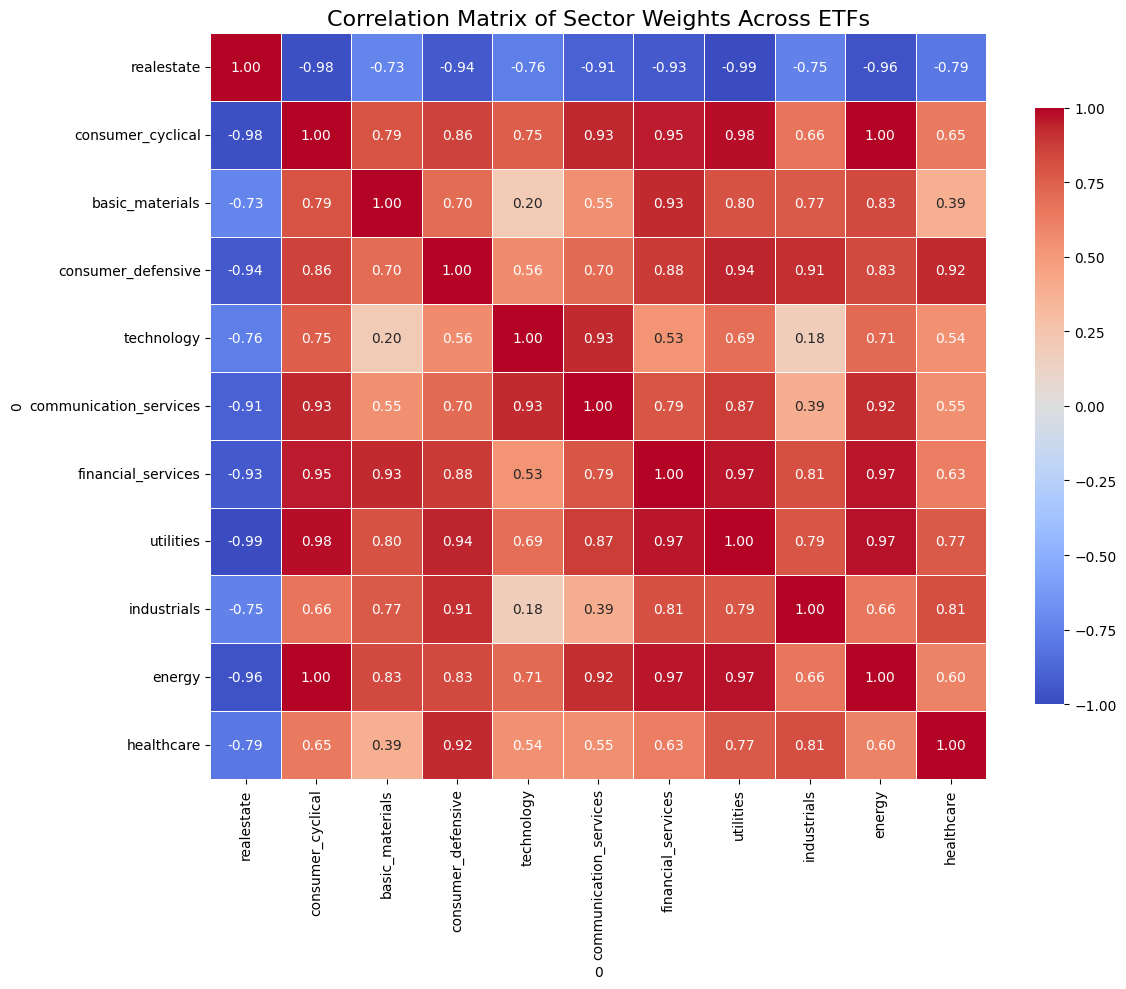

In [21]:
plt.figure(figsize=(12, 10))

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, fmt='.2f', cbar_kws={"shrink": 0.8})

# Add title and adjust layout
plt.title('Correlation Matrix of Sector Weights Across ETFs', fontsize=16)
plt.tight_layout()
plt.show()